In [89]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models, Sequential
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import vgg16
from turtle import shape
import tensorflow_datasets as tfds
import numpy as np
import PIL
import os

In [90]:
data_dir = 'TrainMarc'


img_height = 360
img_width = 360
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1140 files belonging to 4 classes.
Using 912 files for training.
Found 1140 files belonging to 4 classes.
Using 228 files for validation.


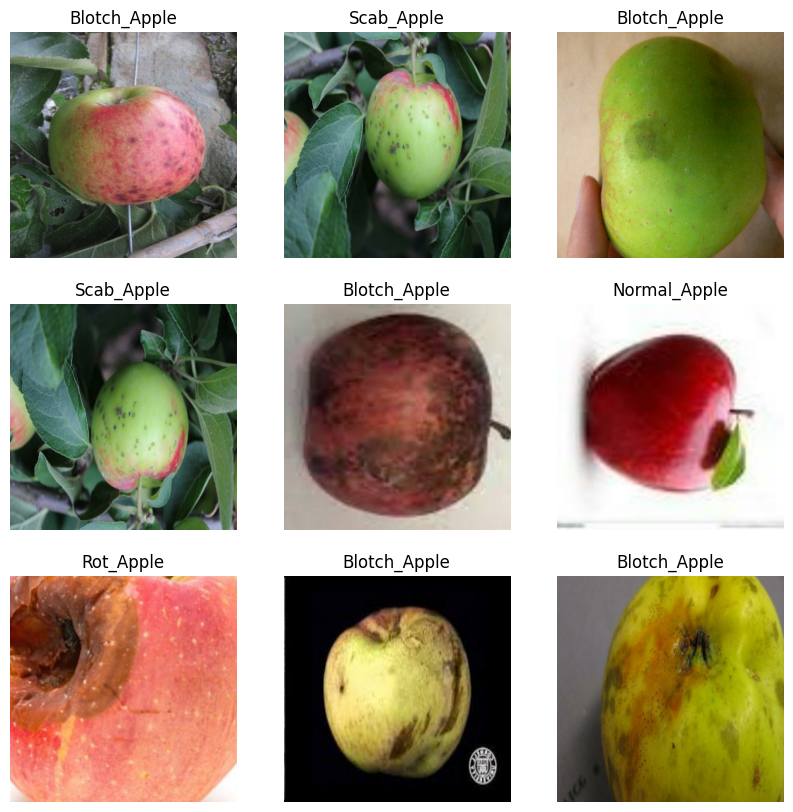

In [91]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

    # plt.show()


In [92]:
print(class_names)
# klasses waarin de apple zit.
# 0= Blotch Apple 
# 1= Normal Apple 
# 2= Rot Apple 
# 3= Scab Apple 

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']


In [93]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 360, 360, 3)
(32,)


In [94]:

data_augmentation = keras.Sequential(
  [ 
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(45),
    layers.RandomZoom(.4),
  ]
)


In [95]:
images = tf.cast(tf.expand_dims(images, 0), tf.float32)

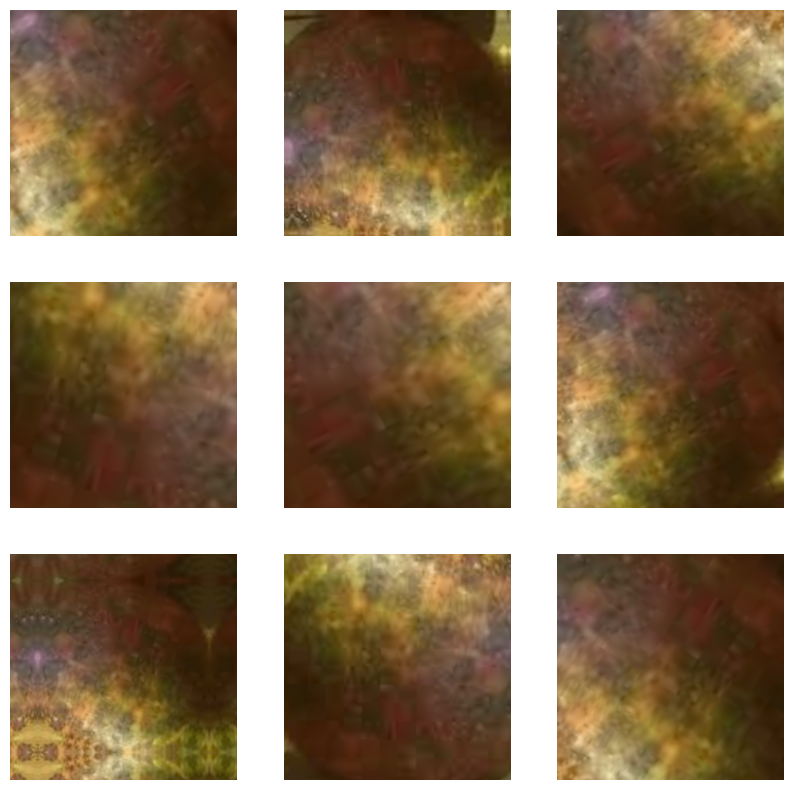

In [96]:
plt.figure(figsize=(10, 10))

image, label = next(iter(train_ds))

for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(image,training=True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [97]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [98]:
normalization_layer = layers.Rescaling(1./255)

In [99]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
#Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [105]:
"""
model = keras.models.Sequential()

model.add(layers.Input(shape=(360, 360, 3)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='softmax'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dropout(0.2))

model.add(layers.Dense(4, activation='relu'))

model.summary()

num_classes = len(class_names)

"""
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(360, 360, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # layers.Conv2D(64, 3, padding='same', activation='relu'),
    # layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4),
    layers.Dense(num_classes),
    ])

model.summary()

""""
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(360,360,3)),
    tf.keras.layers.Conv2D(16, 3, padding= 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, 3, padding= 'same', activation='softmax'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, 3, padding= 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4),
    ])

model.summary()

"""


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 360, 360, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 360, 360, 16)      448       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 180, 180, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 180, 180, 32)      4640      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 90, 90, 32)      

'"\nmodel = tf.keras.models.Sequential([\n    tf.keras.layers.Input(shape=(360,360,3)),\n    tf.keras.layers.Conv2D(16, 3, padding= \'same\', activation=\'relu\'),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Conv2D(16, 3, padding= \'same\', activation=\'softmax\'),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Conv2D(16, 3, padding= \'same\', activation=\'relu\'),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Flatten(),\n    tf.keras.layers.Dropout(0.2),\n    tf.keras.layers.Dense(4),\n    ])\n\nmodel.summary()\n\n'

In [106]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [107]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
29/29 [==============================] - 27s 899ms/step - loss: 1.3179 - accuracy: 0.4057 - val_loss: 1.2679 - val_accuracy: 0.4298
Epoch 2/15
29/29 [==============================] - 29s 1000ms/step - loss: 1.1048 - accuracy: 0.5417 - val_loss: 1.0083 - val_accuracy: 0.5789
Epoch 3/15
29/29 [==============================] - 29s 985ms/step - loss: 0.9041 - accuracy: 0.6513 - val_loss: 0.8952 - val_accuracy: 0.6711
Epoch 4/15
29/29 [==============================] - 31s 1s/step - loss: 0.8198 - accuracy: 0.6798 - val_loss: 0.9489 - val_accuracy: 0.6491
Epoch 5/15
29/29 [==============================] - 32s 1s/step - loss: 0.7299 - accuracy: 0.7270 - val_loss: 0.8309 - val_accuracy: 0.6798
Epoch 6/15
29/29 [==============================] - 33s 1s/step - loss: 0.5862 - accuracy: 0.7774 - val_loss: 0.7832 - val_accuracy: 0.7105
Epoch 7/15
29/29 [==============================] - 30s 1s/step - loss: 0.5078 - accuracy: 0.8191 - val_loss: 0.7511 - val_accuracy: 0.7149
Epoch 8/15

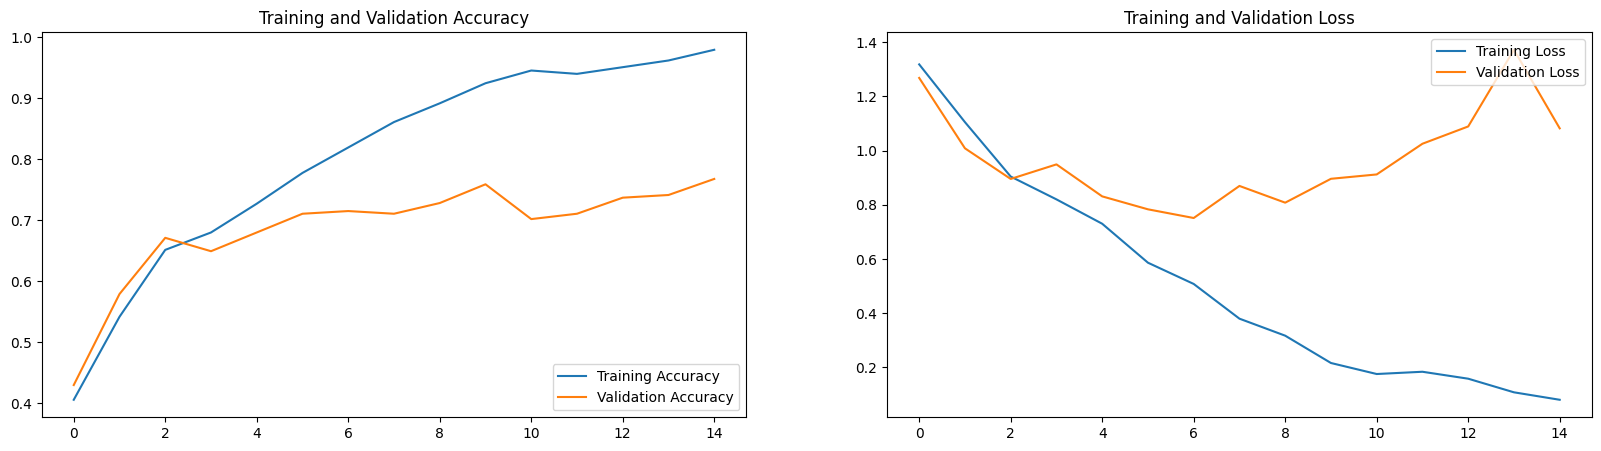

In [109]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

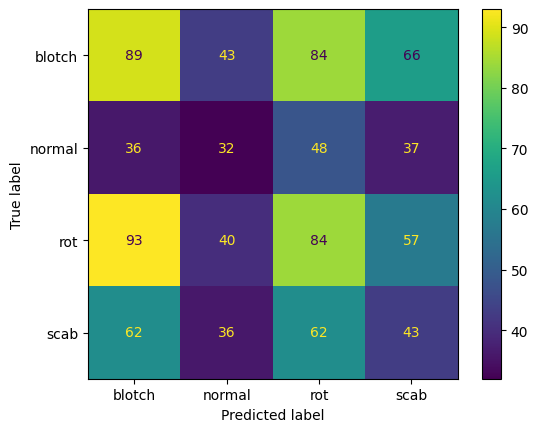

In [110]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

batchPredictions = model.predict(train_ds)
predicted_categories = tf.argmax(batchPredictions, axis=1)
true_categories = tf.concat([y for x, y in train_ds], axis=0)
cm = confusion_matrix(true_categories, predicted_categories)
cmd = ConfusionMatrixDisplay(cm, display_labels=['blotch','normal','rot','scab'])
cmd.plot()
